# 使用LR和SVM对 Rental Listing Inquiries 数据中公寓受欢迎程度进行分类

In [1]:
# 首先 import 必要的模块
import pandas as pd 
import numpy as np

#用于计算feature字段的文本特征提取
from sklearn.feature_extraction.text import  CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer

#CountVectorizer为稀疏特征，特征编码结果存为稀疏矩阵xgboost处理更高效
from scipy import sparse

#对类别型特征进行编码
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV
# 数据分割
from sklearn.model_selection import train_test_split
# 数据标准化
from sklearn.preprocessing import StandardScaler
# 在这个作业中用正确率作为模型预测性能的度量（SVM并不能直接输出各类的概率）
from sklearn.metrics import accuracy_score

from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 数据读取

In [2]:
# 读取数据
dpath = './week2data_RentListingInquries/'
traindata = pd.read_json(dpath + "RentListingInquries_train.json")
testdata = pd.read_json(dpath + "RentListingInquries_test.json")

In [3]:
traindata.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,low
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,high
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,low
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street,low


In [4]:
testdata.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street
1,1.0,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,d0b5648017832b2427eeb9956d966a14,[https://photos.renthop.com/2/7210040_d824cc71...,2850,176 Thompson Street
100,1.0,1,3dbbb69fd52e0d25131aa1cd459c87eb,2016-06-03 04:29:40,New York chic has reached a new level ...,101 East 10th Street,"[Doorman, Elevator, No Fee]",40.7306,7103890,-73.9890,9ca6f3baa475c37a3b3521a394d65467,[https://photos.renthop.com/2/7103890_85b33077...,3758,101 East 10th Street
1000,1.0,2,783d21d013a7e655bddc4ed0d461cc5e,2016-06-11 06:17:35,Step into this fantastic new Construction in t...,South Third Street\r,"[Roof Deck, Balcony, Elevator, Laundry in Buil...",40.7109,7143442,-73.9571,0b9d5db96db8472d7aeb67c67338c4d2,[https://photos.renthop.com/2/7143442_0879e9e0...,3300,251 South Third Street\r
100000,2.0,2,6134e7c4dd1a98d9aee36623c9872b49,2016-04-12 05:24:17,"~Take a stroll in Central Park, enjoy the ente...","Midtown West, 8th Ave","[Common Outdoor Space, Cats Allowed, Dogs Allo...",40.7650,6860601,-73.9845,b5eda0eb31b042ce2124fd9e9fcfce2f,[https://photos.renthop.com/2/6860601_c96164d8...,4900,260 West 54th Street


## 数据基本信息

In [5]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 15 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null object
description        49352 non-null object
display_address    49352 non-null object
features           49352 non-null object
latitude           49352 non-null float64
listing_id         49352 non-null int64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null int64
street_address     49352 non-null object
interest_level     49352 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


In [6]:
# 查看是否有空值
traindata.isnull().sum()

bathrooms          0
bedrooms           0
building_id        0
created            0
description        0
display_address    0
features           0
latitude           0
listing_id         0
longitude          0
manager_id         0
photos             0
price              0
street_address     0
interest_level     0
dtype: int64

In [7]:
# 各属性的统计特性
traindata.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


In [8]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74659 entries, 0 to 99999
Data columns (total 14 columns):
bathrooms          74659 non-null float64
bedrooms           74659 non-null int64
building_id        74659 non-null object
created            74659 non-null object
description        74659 non-null object
display_address    74659 non-null object
features           74659 non-null object
latitude           74659 non-null float64
listing_id         74659 non-null int64
longitude          74659 non-null float64
manager_id         74659 non-null object
photos             74659 non-null object
price              74659 non-null int64
street_address     74659 non-null object
dtypes: float64(3), int64(3), object(8)
memory usage: 8.5+ MB


In [9]:
# 查看是否有空值
testdata.isnull().sum()

bathrooms          0
bedrooms           0
building_id        0
created            0
description        0
display_address    0
features           0
latitude           0
listing_id         0
longitude          0
manager_id         0
photos             0
price              0
street_address     0
dtype: int64

In [10]:
# 各属性的统计特性
testdata.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,74659.000000,74659.000000,74659.000000,7.465900e+04,74659.000000,7.465900e+04
mean,1.212915,1.544663,40.735060,7.024001e+06,-73.945282,3.749033e+03
std,0.649820,1.107014,0.806687,1.264496e+05,1.487795,9.713092e+03
min,0.000000,0.000000,0.000000,6.811958e+06,-121.488000,1.000000e+00
25%,1.000000,1.000000,40.727800,6.915516e+06,-73.991800,2.495000e+03
50%,1.000000,1.000000,40.751600,7.021738e+06,-73.977700,3.150000e+03
75%,1.000000,2.000000,40.774300,7.129166e+06,-73.954700,4.100000e+03
max,112.000000,7.000000,42.872700,7.761779e+06,0.000000,1.675000e+06


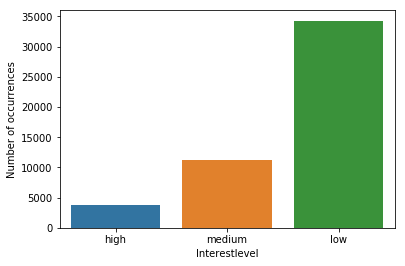

In [11]:
# 受欢迎程度 分布，看看各类样本分布是否均衡
sns.countplot(traindata.interest_level, order=['high', 'medium', 'low']);
pyplot.xlabel('Interestlevel');
pyplot.ylabel('Number of occurrences');

小结：    
1、训练和测试数据中没有缺失值；     
2、可以用有序数组对感兴趣等级进行编码；    
3、各类样本不均衡，使用交叉验证对分类任务缺省的StratifiedKFold（分层交叉验证），在每折采样时根据各类样本按比例采样；   
4、building_id、listing_id和manager_id为id，无实际意义，可删除这3个特征。

## 数据探索

#### 删除无用特征

In [12]:
# building_id、listing_id和manager_id为id，无实际意义,删除这3个特征
traindata.drop(['building_id', 'listing_id','manager_id'], axis = 1, inplace = True)
testdata.drop(['building_id', 'listing_id','manager_id'], axis = 1, inplace = True)

In [13]:
traindata.head()

,bathrooms,bedrooms,created,description,display_address,features,latitude,longitude,photos,price,street_address,interest_level
10,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,-73.9425,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
10000,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",40.7947,-73.9667,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,low
100004,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",40.7388,-74.0018,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,high
100007,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",40.7539,-73.9677,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street,low
100013,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],40.8241,-73.9493,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street,low


### 特征工程

#### bathrooms 浴室数量

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


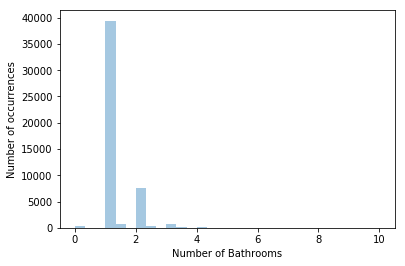

In [14]:
fig = pyplot.figure()
sns.distplot(traindata.bathrooms.values, bins=30, kde=False)
pyplot.xlabel('Number of Bathrooms', fontsize=10)
pyplot.ylabel('Number of occurrences', fontsize=10)
pyplot.show()

Text(0.5,1,'Number of Bathrooms Vs Interest_level')

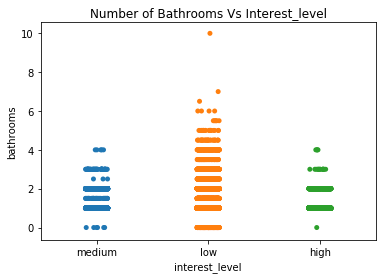

In [15]:
# 查看浴室数量和感兴趣程度间关系
sns.stripplot(traindata["interest_level"],traindata["bathrooms"], jitter=True)
pyplot.title("Number of Bathrooms Vs Interest_level")

由图中可以看出大部分样本的浴室数目集中在0到4之间，有一个样本为数目10，查看该样本的卧室数量是否大于等于浴室数量。

In [16]:
traindata[traindata["bathrooms"] == 10]

,bathrooms,bedrooms,created,description,display_address,features,latitude,longitude,photos,price,street_address,interest_level
104459,10.0,2,2016-04-09 04:34:31,***The building?s well-attended lobby welcomes...,W 52 St.,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7633,-73.9849,[https://photos.renthop.com/2/6849204_1f92b58a...,3600,260 W 52 St.,low


浴室数目为10的样本，对应的卧室数目为2，按照常理，一般2卧室的房子拥有1间浴室，因此将此样本的浴室数目改为1.

In [17]:
traindata["bathrooms"] = traindata["bathrooms"].replace(10, 1)

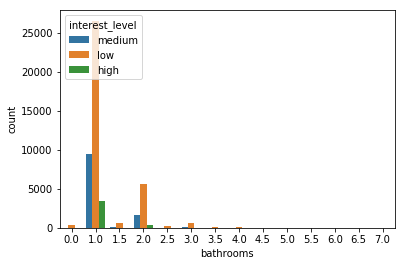

In [18]:
# 绘制浴室数量和感兴趣程度的直方图
sns.countplot(x="bathrooms", hue="interest_level",data=traindata)

由直方图可以看出，当浴室数量为0时，感兴趣程度均为低。

#### price 价格

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


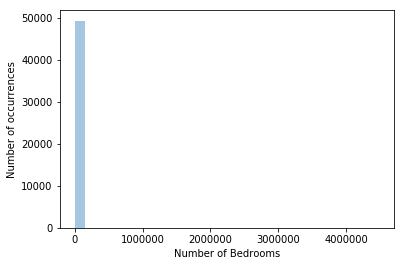

In [19]:
fig = pyplot.figure()
sns.distplot(traindata.price.values, bins=30, kde=False)
pyplot.xlabel('Number of Bedrooms', fontsize=10)
pyplot.ylabel('Number of occurrences', fontsize=10)
pyplot.show()

Text(0.5,1,'Number of price Vs Interest_level')

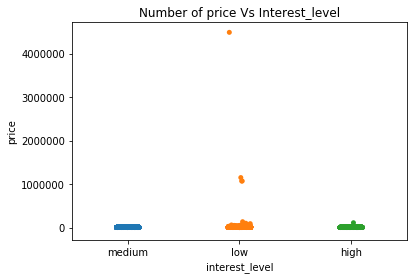

In [20]:
# 查看浴室数量和感兴趣程度间关系
sns.stripplot(traindata["interest_level"],traindata["price"], jitter=True)
pyplot.title("Number of price Vs Interest_level")

由图中可以看出大部分房屋租金都在1万以下，个别样本价格超过了50万，查看这几个样本的房间数量是否物有所值。

In [21]:
traindata[traindata["price"] > 500000]

,bathrooms,bedrooms,created,description,display_address,features,latitude,longitude,photos,price,street_address,interest_level
12168,1.0,2,2016-06-24 05:02:58,,West 116th Street,"[Doorman, Elevator, Cats Allowed, Dogs Allowed...",40.8011,-73.9480,[],1150000,40 West 116th Street,low
32611,1.0,2,2016-06-24 05:02:11,,Hudson Street,"[Doorman, Elevator, Cats Allowed, Dogs Allowed...",40.7299,-74.0071,[],4490000,421 Hudson Street,low
55437,1.0,1,2016-05-14 05:21:28,,West 57th Street,"[Doorman, Cats Allowed, Dogs Allowed]",40.7676,-73.9844,[],1070000,333 West 57th Street,low
57803,1.0,1,2016-05-19 02:37:06,This 1 Bedroom apartment is located on a prime...,West 57th Street,"[Doorman, Elevator, Pre-War, Dogs Allowed, Cat...",40.7676,-73.9844,[https://photos.renthop.com/2/7036279_924b52f0...,1070000,333 West 57th Street,low


由上表可以看出，4个价格远超其他房屋价格的样本，房间数量不超过2，因此，考虑这几个样本的价格值为异常值，予以剔除。

In [22]:
traindata = traindata.loc[traindata.price < 500000]

Text(0.5,1,'Number of price Vs Interest_level')

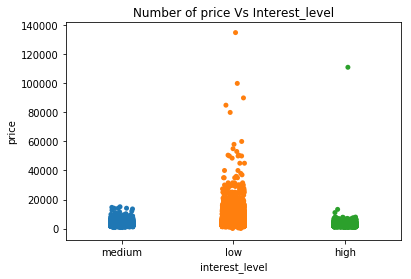

In [23]:
# 查看浴室数量和感兴趣程度间关系
sns.stripplot(traindata["interest_level"],traindata["price"], jitter=True)
pyplot.title("Number of price Vs Interest_level")

由上图可以看出：  
大部分样本房屋价格都小于4000；  
兴趣程度高和中等的房屋价格均偏低，一般不超过2万，有个别兴趣程度高的样本价格超过10万，查看这些样本看是否合理。

In [24]:
traindata[(traindata["price"] > 100000) & (traindata["interest_level"] == "high")]

,bathrooms,bedrooms,created,description,display_address,features,latitude,longitude,photos,price,street_address,interest_level
4620,1.0,0,2016-06-07 17:35:10,The BEST DEAL!!!!!\r\rBeautiful Studio in a ni...,Van Horn St and 57th ave,"[Elevator, Laundry In Building, Balcony]",40.7323,-73.8761,[https://photos.renthop.com/2/7122037_531f0877...,111111,57-25 Van Horn St,high


上表所示样本房间数目为0，房屋价格为11万，显然不符合实际，为异常样本，予以删除。

In [25]:
traindata = traindata[(traindata["price"] <= 100000) | (traindata["interest_level"] != "high")]

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


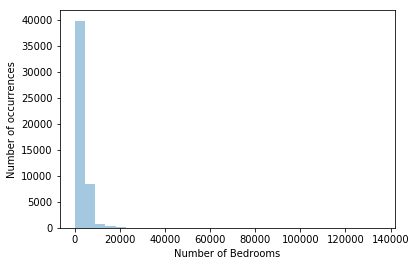

In [26]:
fig = pyplot.figure()
sns.distplot(traindata.price.values, bins=30, kde=False)
pyplot.xlabel('Number of Bedrooms', fontsize=10)
pyplot.ylabel('Number of occurrences', fontsize=10)
pyplot.show()

#### Bedrooms 卧室数量

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


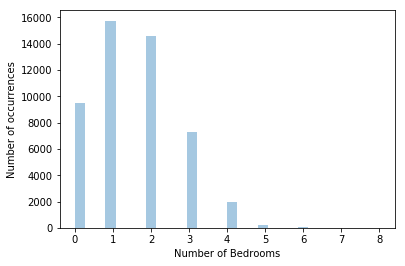

In [27]:
fig = pyplot.figure()
sns.distplot(traindata.bedrooms.values, bins=30, kde=False)
pyplot.xlabel('Number of Bedrooms', fontsize=10)
pyplot.ylabel('Number of occurrences', fontsize=10)
pyplot.show()

由上图可以看出，存在大量房源，房间数为0，显然不合理，因此类样本数量多，不能直接删除，先查看这些房间数为0的样本。

In [28]:
traindata[traindata["bedrooms"] == 0]

,bathrooms,bedrooms,created,description,display_address,features,latitude,longitude,photos,price,street_address,interest_level
100030,1.0,0,2016-04-14 01:10:30,New to the market! Spacious studio located in ...,York Avenue,[],40.7769,-73.9467,[https://photos.renthop.com/2/6869199_06b2601f...,1950,1661 York Avenue,low
100051,1.0,0,2016-04-18 02:36:00,Stunning full renovated studio unit. High cei...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,-73.9743,[https://photos.renthop.com/2/6889043_a3e1c004...,2350,340 East 34th Street,medium
100083,1.0,0,2016-04-21 02:17:28,Enjoy the Upper West Side life-style! This ap...,250 West 88th Street,"[Doorman, Elevator, Pre-War, Exclusive, Dogs A...",40.7897,-73.9760,[https://photos.renthop.com/2/6904268_657c825a...,2750,250 West 88th Street,medium
100096,1.0,0,2016-04-04 03:47:57,Location: 141st St. and Malcolm X BlvdSubway: ...,West 141st Street,"[prewar, Dogs Allowed, Cats Allowed, LOWRISE, ...",40.8184,-73.9389,[https://photos.renthop.com/2/6821706_bf71ecb1...,1300,111-115 West 141st Street,low
100098,1.0,0,2016-04-17 02:16:42,Located in one of Manhattan's most desirable a...,West 58th Street,"[Doorman, Elevator, Pre-War, Dishwasher, Dogs ...",40.7649,-73.9763,[https://photos.renthop.com/2/6885742_51e79649...,1980,57 West 58th Street,high
10010,1.0,0,2016-06-29 04:08:35,Prime Location!! This Luxury Chelsea building ...,W 34 St.,"[Roof Deck, Doorman, Elevator, Fitness Center,...",40.7530,-73.9959,[https://photos.renthop.com/2/7230670_5757b0e5...,2396,360 W 34 St.,medium
100107,1.0,0,2016-04-19 06:19:44,Wonderful Upper East Side location! This quiet...,East 82nd Street,"[Balcony, Elevator, Garden/Patio, Terrace, Dis...",40.7753,-73.9540,[https://photos.renthop.com/2/6896742_10c69ade...,2400,240 East 82nd Street,medium
100112,1.0,0,2016-04-29 05:27:33,Modern postwar building located in the heart o...,1 Ave,"[Elevator, Loft, Laundry in Building, Dishwash...",40.7739,-73.9511,[https://photos.renthop.com/2/6942606_35305529...,1850,1570 1 Ave,medium
100117,1.0,0,2016-04-29 04:31:19,Great gut -renovated apartment in charming ele...,W 13 Street,"[Elevator, Loft, Laundry in Building, Dishwash...",40.7372,-73.9981,[https://photos.renthop.com/2/6941997_740e97f8...,2650,117 W 13 Street,low
100131,1.0,0,2016-04-12 06:10:58,Located in a beautiful and classic pre-war bui...,E 88 St.,"[Doorman, Elevator, Laundry in Building, Laund...",40.7817,-73.9573,[https://photos.renthop.com/2/6861960_2521d86d...,3500,60 E 88 St.,low


因为一般情况下浴室数量会小于等于房间数量，而房间数为0的样本，浴室数量基本都为1，因此，对于房间数为0的样本，用浴室数量替换房间数量。

In [29]:
Tempbedroom0 = traindata[traindata['bedrooms'] == 0]
Tempbedroom0['bedrooms'] = Tempbedroom0['bathrooms']
Temptraindata = traindata[traindata['bedrooms'] != 0]
print(Tempbedroom0.shape)
print(Temptraindata.shape)
print(traindata.shape)
traindata = pd.concat([Tempbedroom0, Temptraindata], ignore_index = False)

(9474, 12)
(39873, 12)
(49347, 12)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


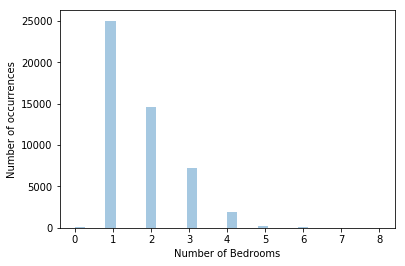

In [30]:
fig = pyplot.figure()
sns.distplot(traindata.bedrooms.values, bins=30, kde=False)
pyplot.xlabel('Number of Bedrooms', fontsize=10)
pyplot.ylabel('Number of occurrences', fontsize=10)
pyplot.show()

#### 经纬度 latitude、longitude

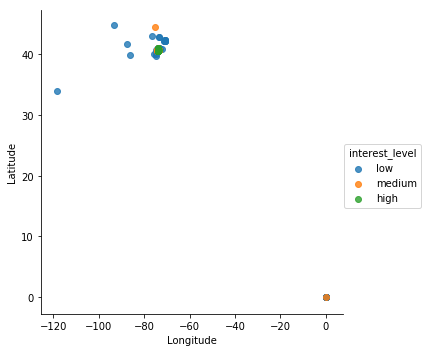

In [31]:
sns.lmplot(x="longitude", y="latitude", fit_reg=False, hue='interest_level',data=traindata);
pyplot.xlabel('Longitude');
pyplot.ylabel('Latitude');

纽约市中心位于北纬40°42'51.67"，西经74°0'21.50"，即纬度40.714352777777776，经度-74.00597222222223。
由上图中很明显看到部分样本不在纽约市内，予以剔除。

In [32]:
# 纽约市中心坐标
NewYorkLat = 40.714352777777776
NewYorkLon = -74.00597222222223

In [33]:
traindata = traindata[(traindata['longitude'] < -73.8) & (traindata['longitude'] > -74.05)]
traindata.shape

(49231, 12)

In [34]:
traindata = traindata[(traindata['latitude'] < 41) & (traindata['latitude'] > 38)]
traindata.shape

(49228, 12)

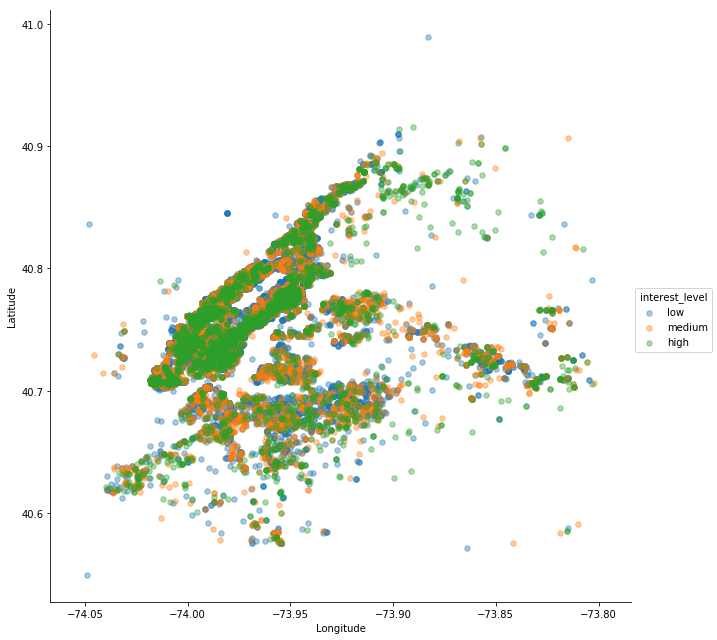

In [35]:
sns.lmplot(x="longitude", y="latitude", fit_reg=False, hue='interest_level',size=9, scatter_kws={'alpha':0.4,'s':30},data=traindata);
pyplot.xlabel('Longitude');
pyplot.ylabel('Latitude');

In [36]:
traindata.head()

,bathrooms,bedrooms,created,description,display_address,features,latitude,longitude,photos,price,street_address,interest_level
100030,1.0,1.0,2016-04-14 01:10:30,New to the market! Spacious studio located in ...,York Avenue,[],40.7769,-73.9467,[https://photos.renthop.com/2/6869199_06b2601f...,1950,1661 York Avenue,low
100051,1.0,1.0,2016-04-18 02:36:00,Stunning full renovated studio unit. High cei...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,-73.9743,[https://photos.renthop.com/2/6889043_a3e1c004...,2350,340 East 34th Street,medium
100083,1.0,1.0,2016-04-21 02:17:28,Enjoy the Upper West Side life-style! This ap...,250 West 88th Street,"[Doorman, Elevator, Pre-War, Exclusive, Dogs A...",40.7897,-73.9760,[https://photos.renthop.com/2/6904268_657c825a...,2750,250 West 88th Street,medium
100096,1.0,1.0,2016-04-04 03:47:57,Location: 141st St. and Malcolm X BlvdSubway: ...,West 141st Street,"[prewar, Dogs Allowed, Cats Allowed, LOWRISE, ...",40.8184,-73.9389,[https://photos.renthop.com/2/6821706_bf71ecb1...,1300,111-115 West 141st Street,low
100098,1.0,1.0,2016-04-17 02:16:42,Located in one of Manhattan's most desirable a...,West 58th Street,"[Doorman, Elevator, Pre-War, Dishwasher, Dogs ...",40.7649,-73.9763,[https://photos.renthop.com/2/6885742_51e79649...,1980,57 West 58th Street,high


#### created 日期

In [37]:
def procdess_created(df):
    df['created'] = pd.to_datetime(df['created'])
    df["year"] = df["created"].dt.year
    df['month'] = df['created'].dt.month
    df['day'] = df['created'].dt.day
    df['hour'] = df['created'].dt.hour
    df['weekday'] = df['created'].dt.weekday
    df['week'] = df['created'].dt.week
    # 季度
    df['quarter'] = df['created'].dt.quarter
    # 是否为假期
    df['weekend'] = ((df['weekday'] == 5) | (df['weekday'] == 6))

    df.drop(['created'], axis=1,inplace = True)

In [38]:
procdess_created(traindata)
procdess_created(testdata)

In [39]:
traindata.head()

,bathrooms,bedrooms,description,display_address,features,latitude,longitude,photos,price,street_address,interest_level,year,month,day,hour,weekday,week,quarter,weekend
100030,1.0,1.0,New to the market! Spacious studio located in ...,York Avenue,[],40.7769,-73.9467,[https://photos.renthop.com/2/6869199_06b2601f...,1950,1661 York Avenue,low,2016,4,14,1,3,15,2,False
100051,1.0,1.0,Stunning full renovated studio unit. High cei...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,-73.9743,[https://photos.renthop.com/2/6889043_a3e1c004...,2350,340 East 34th Street,medium,2016,4,18,2,0,16,2,False
100083,1.0,1.0,Enjoy the Upper West Side life-style! This ap...,250 West 88th Street,"[Doorman, Elevator, Pre-War, Exclusive, Dogs A...",40.7897,-73.9760,[https://photos.renthop.com/2/6904268_657c825a...,2750,250 West 88th Street,medium,2016,4,21,2,3,16,2,False
100096,1.0,1.0,Location: 141st St. and Malcolm X BlvdSubway: ...,West 141st Street,"[prewar, Dogs Allowed, Cats Allowed, LOWRISE, ...",40.8184,-73.9389,[https://photos.renthop.com/2/6821706_bf71ecb1...,1300,111-115 West 141st Street,low,2016,4,4,3,0,14,2,False
100098,1.0,1.0,Located in one of Manhattan's most desirable a...,West 58th Street,"[Doorman, Elevator, Pre-War, Dishwasher, Dogs ...",40.7649,-73.9763,[https://photos.renthop.com/2/6885742_51e79649...,1980,57 West 58th Street,high,2016,4,17,2,6,15,2,True


#### photos 照片

In [40]:
# 取照片数量作为特征并删除照片网址
traindata['num_photos'] = traindata['photos'].apply(len)
ulimit = np.percentile(traindata.num_photos.values, 99)
traindata['num_photos'].loc[traindata['num_photos']>ulimit] = ulimit

testdata['num_photos'] = testdata['photos'].apply(len)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


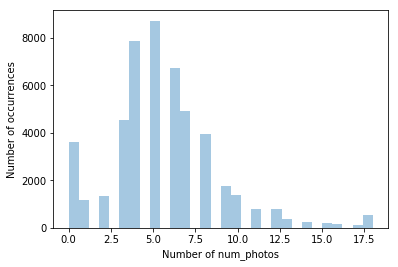

In [41]:
fig = pyplot.figure()
sns.distplot(traindata.num_photos.values, bins=30, kde=False)
pyplot.xlabel('Number of num_photos', fontsize=10)
pyplot.ylabel('Number of occurrences', fontsize=10)
pyplot.show()

In [42]:
# 删除photos特征
traindata.drop(['photos'], axis = 1, inplace = True)
testdata.drop(['photos'], axis = 1, inplace = True)

#### features 特点

In [43]:
# 添加特点数量属性，因为感兴趣程度与特点数量有关，特点越多描述越详细，且写出来的大多为优点
traindata['num_features'] = traindata['features'].apply(len)
testdata['num_features'] = testdata['features'].apply(len)

In [44]:
def procdess_features_train_test(df_train, df_test):
    n_train_samples = len(df_train.index)
    
    df_train_test = pd.concat((df_train, df_test), axis=0)
    df_train_test['features2'] = df_train_test['features']
    df_train_test['features2'] = df_train_test['features2'].apply(lambda x: ' '.join(x))

    c_vect = CountVectorizer(stop_words='english', max_features=200, ngram_range=(1, 1), decode_error='ignore')
    c_vect_sparse = c_vect.fit_transform(df_train_test['features2'])
    c_vect_sparse_cols = c_vect.get_feature_names()

    df_train.drop(['features'], axis=1, inplace=True)
    df_test.drop(['features'], axis=1, inplace=True)
    
#     #hstack作为特征处理的最后一部，先将其他所有特征都转换成数值型特征才能处理,稀疏表示
#     df_train_sparse = sparse.hstack([df_train, c_vect_sparse[:n_train_samples,:]]).tocsr()
#     df_test_sparse = sparse.hstack([df_test, c_vect_sparse[n_train_samples:,:]]).tocsr()
    
    #常规datafrmae
    tmp = pd.DataFrame(c_vect_sparse.toarray()[:n_train_samples,:],columns = c_vect_sparse_cols, index=df_train.index)
    df_train = pd.concat([df_train, tmp], axis=1)
    
    tmp = pd.DataFrame(c_vect_sparse.toarray()[n_train_samples:,:],columns = c_vect_sparse_cols, index=df_test.index)
    df_test = pd.concat([df_test, tmp], axis=1)
    
    #df_test = pd.concat([df_test, tmp[n_train_samples:,:]], axis=1)
  
    return df_train, df_test
#     return df_train_sparse,df_test_sparse,df_train, df_test

In [45]:
traindata, testdata = procdess_features_train_test(traindata, testdata)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  after removing the cwd from sys.path.


#### display_address 地址、street_address 街道地址、description 描述

In [46]:
traindata.drop(['display_address', 'street_address', 'description'], axis = 1, inplace = True)
testdata.drop(['display_address', 'street_address', 'description'], axis = 1, inplace = True)

#### 因数据量大，电脑运行速度过慢跑不起来，故截取10000组数据作为训练和测试数据

In [47]:
traindata = traindata.sample(n = 10000)
traindata.shape

(10000, 216)

In [54]:
testdata = testdata.sample(n = 10000)
testdata.shape

(10000, 215)

添加特征distance表示房屋距市中心距离

In [48]:
from math import radians, cos, sin, asin, sqrt

#根据经纬度位置计算两点间距离
def geodistance(lng1,lat1,lng2,lat2):
    lng1 = lng1/180*3.14159
    lat1 = lat1/180*3.14159
    lng2 = lng2/180*3.14159
    lat2 = lat2/180*3.14159
    lng1, lat1, lng2, lat2 = map(radians, [lng1, lat1, lng2, lat2])
    dlon=lng2-lng1
    dlat=lat2-lat1
    a=sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2 
    dis=2*asin(sqrt(a))*6371*1000
    return dis

In [49]:
traindata['distance'] = 0
# testdata['distance'] = 0
trainsize = traindata.shape[0]
testsize = testdata.shape[0]

for i in range(0, trainsize):
    traindata.iloc[i].distance = geodistance(traindata.iloc[i].longitude, traindata.iloc[i].latitude, NewYorkLon, NewYorkLat)
# for i in range(0, testsize):
#     testdata.iloc[i].distance = geodistance(testdata.iloc[i].longitude, testdata.iloc[i].latitude, NewYorkLon, NewYorkLat)

#### interest_level 感兴趣等级

In [50]:
# 用有序数字替换感兴趣等级，low = 0, medium = 1, high = 2
traindata['interest_level'] = np.where(traindata.interest_level=='low', 0,np.where(traindata.interest_level=='medium', 1, 2))

## 模型选择

### 数据预处理

In [60]:
X_train = traindata.drop(['interest_level'], axis = 1, inplace = False)
y_train = traindata['interest_level']
X_test = testdata

# 初始化特征的标准化器
ss_X = StandardScaler()

# 分别对训练和测试数据的特征进行标准化处理
X_train = ss_X.fit_transform(X_train)
# X_test = ss_X.transform(X_test)

### Logistic 回归

#### Logistic 回归默认参数

In [61]:
from sklearn.linear_model import LogisticRegression
lr= LogisticRegression()

In [62]:
# 交叉验证用于评估模型性能和进行参数调优（模型选择）
#分类任务中交叉验证缺省是采用StratifiedKFold
from sklearn.cross_validation import cross_val_score
accuracy = cross_val_score(lr, X_train, y_train, cv=5) # 5折交叉验证   
print('accuracy of each fold is: ',accuracy)
print('cv accuracy is:', accuracy.mean())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


accuracy of each fold is:  [0.69115442 0.69915042 0.69965017 0.68834417 0.70520521]
cv accuracy is: 0.6967008799560007


#### 正则化的 Logistic Regression及参数调优

In [64]:
#需要调优的参数
# 请尝试将L1正则和L2正则分开，并配合合适的优化求解算法（slover）
#tuned_parameters = {'penalty':['l1','l2'],
#                   'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
#                   }
penaltys = ['l1','l2']
Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
tuned_parameters = dict(penalty = penaltys, C = Cs)

lr_penalty= LogisticRegression()
grid= GridSearchCV(lr_penalty, tuned_parameters,cv=5 ) # scoring='neg_log_loss'
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [65]:
# view the complete results (list of named tuples)
grid.cv_results_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

{'mean_fit_time': array([2.01261711e-01, 7.05910921e-01, 3.37696123e-01, 1.42419090e+00,
        2.37305174e+00, 3.29019895e+00, 1.50455516e+01, 8.45318718e+00,
        1.45645985e+02, 1.73695338e+01, 3.01823798e+02, 2.42738665e+01,
        4.22710814e+02, 2.69307583e+01]),
 'std_fit_time': array([3.36097167e-03, 1.16206477e-02, 1.49616880e-02, 4.52359116e-02,
        1.40260496e+00, 7.58307386e-02, 4.40912419e+00, 4.81625325e-01,
        2.02549268e+01, 9.31015175e-01, 4.88775317e+01, 2.16880957e+00,
        1.09566670e+02, 2.14179728e+00]),
 'mean_score_time': array([0.00179629, 0.00199661, 0.00219526, 0.0019958 , 0.00219479,
        0.00199609, 0.00199609, 0.0017982 , 0.00239348, 0.00199623,
        0.0019958 , 0.00219488, 0.00199647, 0.00179648]),
 'std_score_time': array([3.98898762e-04, 8.06404806e-07, 7.46442334e-04, 1.46971083e-06,
        3.98684503e-04, 1.50336101e-06, 1.43368686e-06, 3.97349277e-04,
        4.88227649e-04, 1.30935003e-06, 1.73898530e-06, 3.98279731e-04,
    

In [66]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.6982
{'C': 0.1, 'penalty': 'l1'}


正则化的 Logistic Regression最优参数为l1正则且C=0.001，最优accuracy为0.695。

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


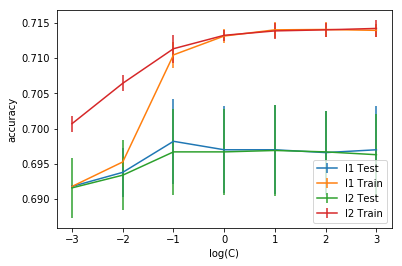

In [67]:
# plot CV误差曲线
test_means = grid.cv_results_[ 'mean_test_score' ]
test_stds = grid.cv_results_[ 'std_test_score' ]
train_means = grid.cv_results_[ 'mean_train_score' ]
train_stds = grid.cv_results_[ 'std_train_score' ]


# plot results
n_Cs = len(Cs)
number_penaltys = len(penaltys)
test_scores = np.array(test_means).reshape(n_Cs,number_penaltys)
train_scores = np.array(train_means).reshape(n_Cs,number_penaltys)
test_stds = np.array(test_stds).reshape(n_Cs,number_penaltys)
train_stds = np.array(train_stds).reshape(n_Cs,number_penaltys)

x_axis = np.log10(Cs)
for i, value in enumerate(penaltys):
    #pyplot.plot(log(Cs), test_scores[i], label= 'penalty:'   + str(value))
    pyplot.errorbar(x_axis, test_scores[:,i], yerr=test_stds[:,i] ,label = penaltys[i] +' Test')
    pyplot.errorbar(x_axis, train_scores[:,i], yerr=train_stds[:,i] ,label = penaltys[i] +' Train')
    
pyplot.legend()
pyplot.xlabel( 'log(C)' )                                                                                                      
pyplot.ylabel( 'accuracy' )
pyplot.savefig('LogisticGridSearchCV_C.png' )

pyplot.show()

### RBFSVM

In [68]:
from sklearn.svm import SVC

In [69]:
def fit_grid_point_RBF(C, gamma, X_train, y_train, X_test, y_test):
    
    # 在训练集是那个利用SVC训练
    SVC3 =  SVC( C = C, kernel='rbf', gamma = gamma)
    SVC3 = SVC3.fit(X_train, y_train)
    
    # 在校验集上返回accuracy
    accuracy = SVC3.score(X_test, y_test)
    
    print("accuracy: {}".format(accuracy))
    return accuracy

In [70]:
#需要调优的参数
C_s = np.logspace(-2, 2, 5)# logspace(a,b,N)把10的a次方到10的b次方区间分成N份 
gamma_s = np.logspace(-2, 2, 5)   

accuracy_s = []
for i, oneC in enumerate(C_s):
    for j, gamma in enumerate(gamma_s):
        tmp = fit_grid_point_RBF(oneC, gamma, X_train, y_train, X_train, y_train)
        accuracy_s.append(tmp)
print("RBF核SVM 最优accuracy：",format(max(accuracy_s)))

accuracy: 0.6918
accuracy: 0.6918
accuracy: 0.6918
accuracy: 0.6918
accuracy: 0.6918
accuracy: 0.6918
accuracy: 0.6918
accuracy: 0.6918
accuracy: 0.6918
accuracy: 0.6918
accuracy: 0.7176
accuracy: 0.871
accuracy: 0.9876
accuracy: 0.9986
accuracy: 1.0
accuracy: 0.821
accuracy: 0.9839
accuracy: 0.9997
accuracy: 1.0
accuracy: 1.0
accuracy: 0.9025
accuracy: 0.9977
accuracy: 1.0
accuracy: 1.0
accuracy: 1.0
RBF核SVM 最优accuracy： 1.0


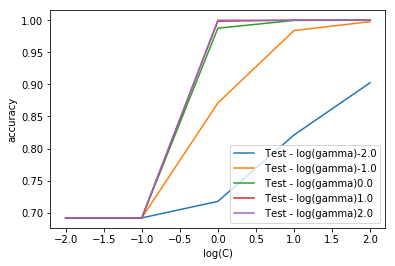

In [71]:
accuracy_s1 = np.array(accuracy_s).reshape(len(C_s),len(gamma_s))
x_axis = np.log10(C_s)
for j, gamma in enumerate(gamma_s):
    pyplot.plot(x_axis, np.array(accuracy_s1[:,j]), label = ' Test - log(gamma)' + str(np.log10(gamma)))

pyplot.legend()
pyplot.xlabel( 'log(C)' )                                                                                                      
pyplot.ylabel( 'accuracy' )
pyplot.savefig('RBF_SVM_Pima.png' )

pyplot.show()

由以上输出数值和图可以看出，当log(gamma)为2，log(C)为0时，即gamma=100 C=1，模型accuracy最高，为1.0。

综上所述，   
Logistic 回归默认参数模型accuracy：        0.6967008799560007      
正则化的 Logistic Regression模型accuracy： 0.6982       
RBF核SVM模型accuracy：                     1.0     
因此，性能最好的模型为RBF核SVM模型。